In [335]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
%matplotlib notebook


In [359]:
filename = "50hr150mVtrig100mVthr.txt"

In [360]:
# formatted for "69hr100mV" (skip 4 rows of the header)

file =  np.loadtxt(filename, float, '#', None, None, skiprows = 4, usecols = (0,1,2,3,4,5))

In [361]:
# assign columns to values
# t = time, a = Pulse Amplitude w = Pulse Width

ch0_t1 = file[:, 0] #s
ch0_a1 = file[:, 1] # V
ch0_w1 = file[:, 2] #s
ch0_t2 = file[:, 3]
ch0_a2 = file[:, 4]
ch0_w2 = file[:, 5]

col_len = len(file[:,0])
ch1_t1 = np.zeros(col_len)
ch1_a1 = np.zeros(col_len)
ch1_w1 = np.zeros(col_len)
ch1_t2 = np.zeros(col_len)
ch1_a2 = np.zeros(col_len)
ch1_w2 = np.zeros(col_len)

In [362]:
def plot_histogram(data,xtitle,ytitle, title, nbins, limits, den = False, ylog = False):
   
    plt.figure()
    #Plot the histogram of the sampled data with nbins and a nice color
    n, bins, patches =plt.hist(data, bins=nbins, range=limits, density = den, color=(0,0.7,0.9))  #Set the color using (r,g,b) values or
                                                                  #  use a built-in matplotlib color""" 
    bincenters = 0.5*(bins[1:]+bins[:-1])
    errs = np.sqrt(n)

    plt.errorbar(bincenters, n, yerr=errs, fmt='none')
    #Add some axis labels and a descriptive title
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title)
    
    if ylog == True:
        plt.yscale('log')
    
    #Get rid of the extra white space on the left/right edges (you can delete these two lines without a problem)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.axis([limits[0],limits[1],ymin,ymax])

    #Not necessarily needed in a Jupyter notebook, but it doesn't hurt
    plt.show()
    return n, bincenters, patches, errs

<IPython.core.display.Javascript object>


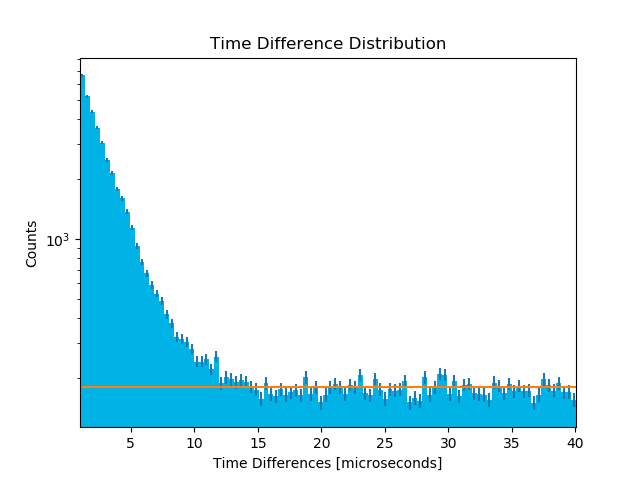

Background average (integer):  180


In [363]:
time_diffs = ch0_t2 - ch0_t1
time_diffs_microsec = time_diffs * (10**6)
nbins = 100
lim = [np.min(time_diffs_microsec), np.max(time_diffs_microsec)]
n, bincenters, patches, errs = plot_histogram(time_diffs_microsec, 'Time Differences [microseconds]', 'Counts', "Time Difference Distribution", nbins, lim, False, True)

# retrieve indices of bins that are 15 us and above

pivot_pt = 10


ind_15_and_above = np.argwhere(bincenters > pivot_pt)
background_counts = n[ind_15_and_above]
background_avg = int(np.average(background_counts))
print('Background average (integer): ', background_avg)

x = np.linspace(0,40,1000)
background_line = np.ones(len(x))*background_avg
plt.plot(x,background_line)
plt.show()

In [298]:
filtered_counts = n - background_avg
# negative counts dont really make sense, so I set negative values to zero.
filtered_counts[np.argwhere(filtered_counts <= 0)] = 1

filtered_counts


array([4.5907e+04, 2.2563e+04, 1.6010e+04, 1.1134e+04, 9.0860e+03,
       7.4230e+03, 6.0730e+03, 5.0200e+03, 4.2220e+03, 3.5610e+03,
       3.1040e+03, 2.3550e+03, 1.8410e+03, 1.5620e+03, 1.3710e+03,
       1.0460e+03, 9.2900e+02, 8.1000e+02, 6.3700e+02, 5.1100e+02,
       4.2000e+02, 3.5300e+02, 3.1500e+02, 2.1700e+02, 1.7000e+02,
       1.9800e+02, 1.2800e+02, 1.2200e+02, 4.8000e+01, 5.0000e+01,
       4.9000e+01, 3.8000e+01, 4.9000e+01, 4.0000e+01, 1.1000e+01,
       1.0000e+00, 2.4000e+01, 5.5000e+01, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3000e+01,
       1.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.3000e+01, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e

<IPython.core.display.Javascript object>


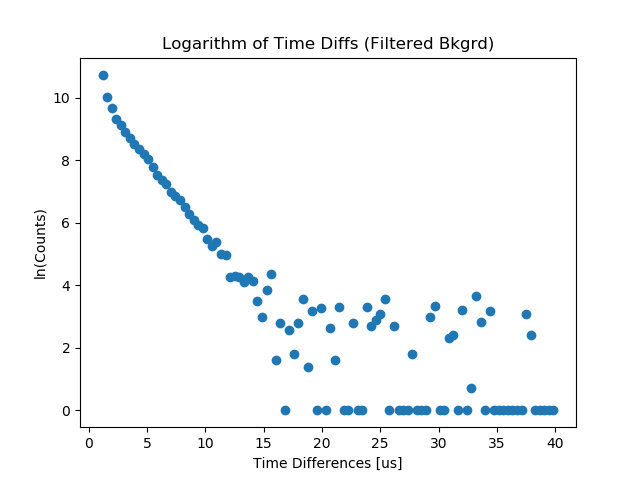

In [364]:
ln_counts = np.log(filtered_counts)
ln_errs = np.log(errs)

plt.figure()
plt.title("Logarithm of Time Diffs (Filtered Bkgrd)")
plt.ylabel("ln(Counts)")
plt.xlabel("Time Differences [us]")
plt.scatter(bincenters, ln_counts)
#plt.errorbar(bincenters, ln_counts, yerr=ln_errs, fmt='none', color = 'g')
plt.show()

<IPython.core.display.Javascript object>


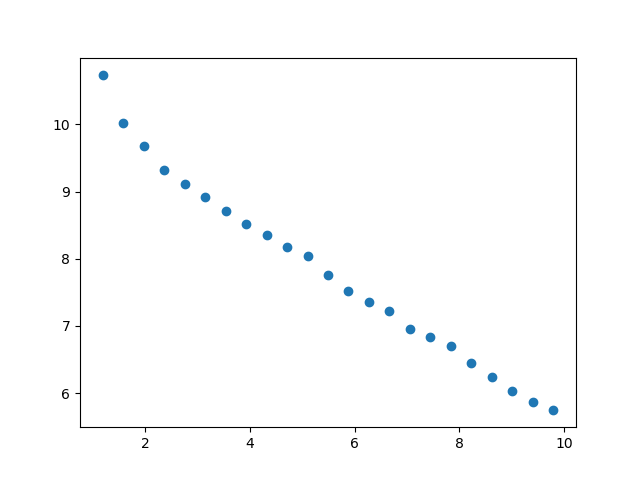

In [308]:
# According to the above, the curve seems linear until the 10th microsecond mark. Thus:

ind_LT_10 = np.argwhere(bincenters <= pivot_pt)
bins_LT10 = bincenters[ind_LT_10]
ln_counts_LT10 = ln_counts[ind_LT_10]
ln_errs_LT10 = ln_errs[ind_LT_10]


plt.figure()
plt.scatter(bins_LT10, ln_counts_LT10)
plt.show()


In [365]:
# For fitting:
def line_func(x, a, b):
    return (a*x + b)


In [366]:
# need to convert to list, because curve_fit didnt like my formatting
bins_list = []
ln_counts_list = []

for i in range(len(bins_LT10)):
    bins_list.append(bins_LT10[i][0])
    ln_counts_list.append(ln_counts_LT10[i][0])
    
#ln_counts_list

In [367]:
popt, pcov = curve_fit(line_func, bins_list, ln_counts_list)
paramerr = np.sqrt(np.diag(pcov))

slope = popt[0]
yint = popt[1]
slope_err = paramerr[0]
yint_err = paramerr[1]

lifetime_est = (-1)/slope
lifetime_est_range = [(-1)/(slope + slope_err), (-1)/(slope - slope_err)]
#N0_est = np.exp(yint)

In [368]:
print("Slope:", slope, "+/-", slope_err)
print("Y-intercept:", yint, "+/-", yint_err)
print("Lifetime estimate: ", lifetime_est)
# print("N0 estimate: ", N0_est)
print("Lifetime estimate range: ", lifetime_est_range)

Slope: -0.5652232244215278 +/- 0.02151928943226629
Y-intercept: 10.93222410020635 +/- 0.2567145152783693
Lifetime estimate:  1.7692125107269614
Lifetime estimate range:  [1.8392362748298863, 1.7043251109108863]


<IPython.core.display.Javascript object>


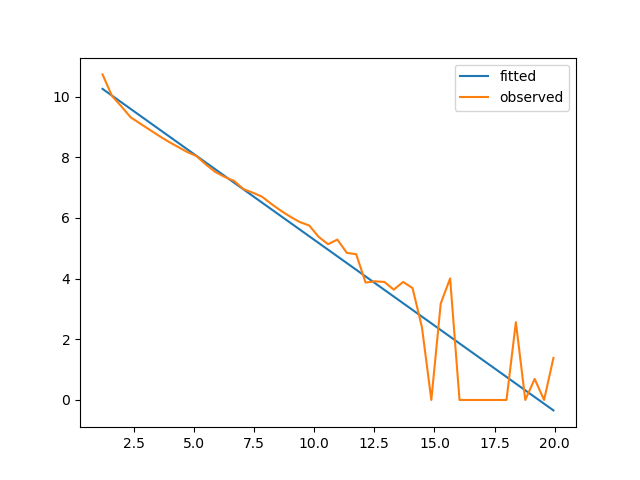

In [369]:
# Finding Chi2 then: generate expected values, then calculate the chi2

fittedvals = line_func(bins_LT10, slope, yint)

plt.figure()
plt.plot(bins_LT10, fittedvals, label = 'fitted')
plt.plot(bins_LT10, ln_counts_LT10, label = 'observed')
plt.legend()
plt.show()

Reduced $\chi^2$ is defined as
$$ \chi^2_{red} = \frac{1}{d} \sum_i \frac{(Obs_i - Exp_i)^2}{\sigma_i^2}$$
where d is the degree of freedom

In [347]:
chi2 = 0
for i in range(len(popt)):
    chi2 += ((ln_counts_LT10[i] - fittedvals[i])**2)/(ln_errs_LT10[i]**2)

df = len(fittedvals) - len(popt)
reduced_chi2 = chi2/df
print('Reduced Chi_2: ', reduced_chi2)

Reduced Chi_2:  [0.00072944]


Redcued chi_2 << 1 indicates overfitting of the model or that the variance has been over-estimated.

<IPython.core.display.Javascript object>


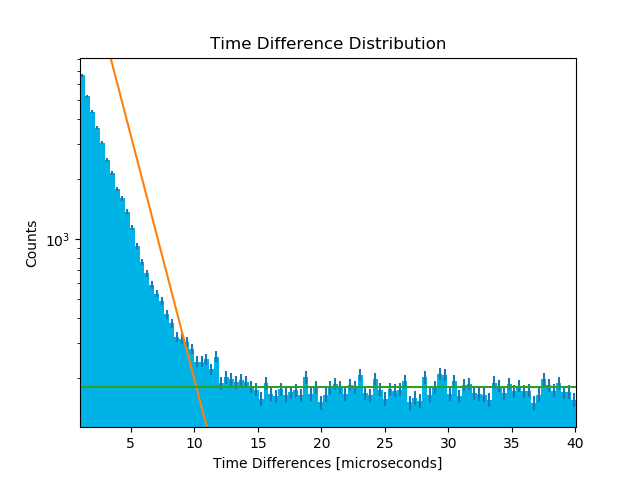

In [370]:
n, bincenters, patches, errs = plot_histogram(time_diffs_microsec, 'Time Differences [microseconds]', 'Counts', "Time Difference Distribution", nbins, lim, False, True)

plt.plot(bins_LT10, np.exp(fittedvals))
plt.plot(x,background_line)

plt.show()

<IPython.core.display.Javascript object>


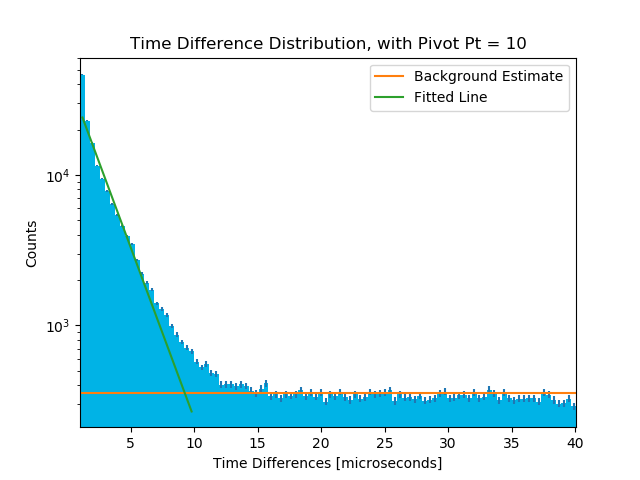

Background average (integer):  356
Slope: -0.5232444024867802 +/- 0.014050355941480323
Y-intercept: 10.712535891147734 +/- 0.0853416107799904
Lifetime estimate:  1.9111527906412054
Lifetime estimate range:  [1.9638878474417436, 1.8611757965502653]
Reduced Chi_2:  [0.00072944]


<IPython.core.display.Javascript object>


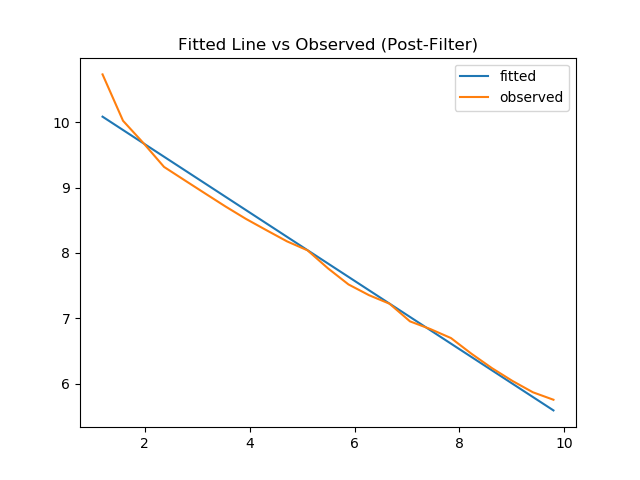

<IPython.core.display.Javascript object>


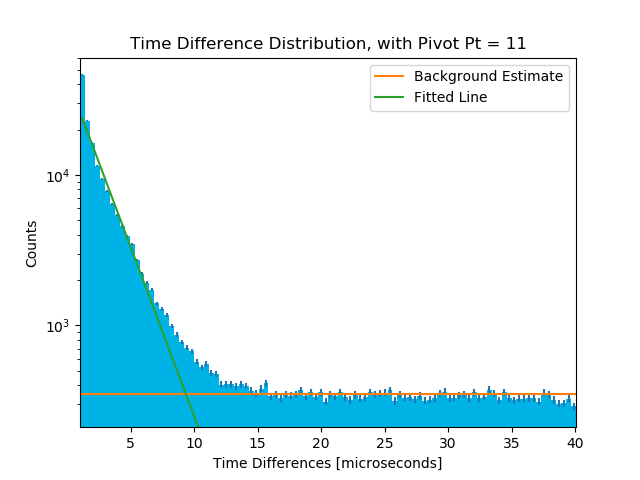

Background average (integer):  348
Slope: -0.5174047956766163 +/- 0.01166978583367175
Y-intercept: 10.687134020873586 +/- 0.07875667046217208
Lifetime estimate:  1.9327227121895696
Lifetime estimate range:  [1.9773200995330515, 1.8900926919328]
Reduced Chi_2:  [0.00072944]


<IPython.core.display.Javascript object>


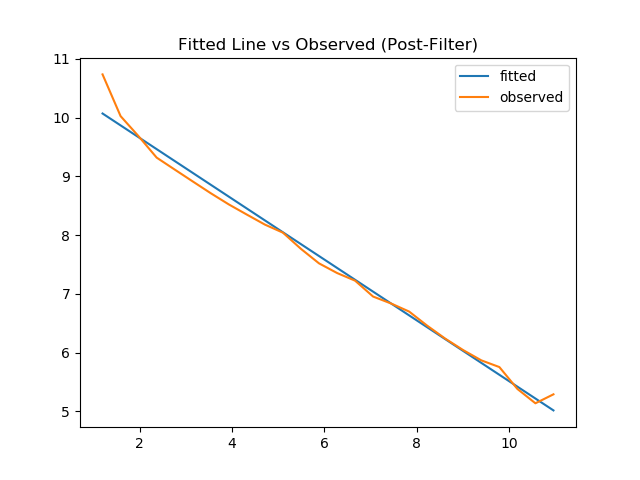

<IPython.core.display.Javascript object>


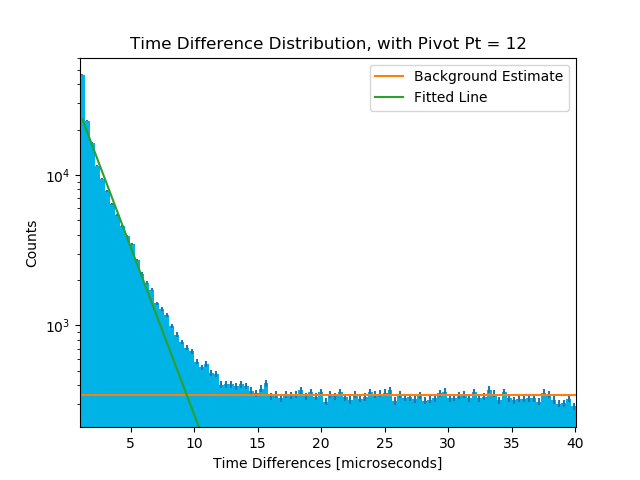

Background average (integer):  344
Slope: -0.5130489715936049 +/- 0.010247953529585753
Y-intercept: 10.66728201063585 +/- 0.07377326503771289
Lifetime estimate:  1.949131672350603
Lifetime estimate range:  [1.9888583437050142, 1.9109609707043236]
Reduced Chi_2:  [0.00068117]


<IPython.core.display.Javascript object>


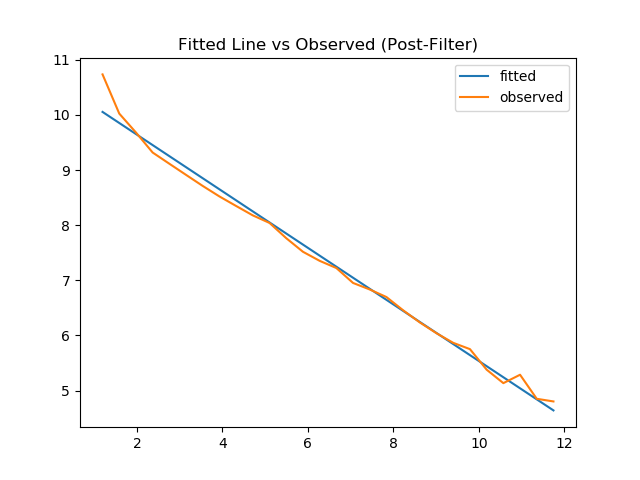

<IPython.core.display.Javascript object>


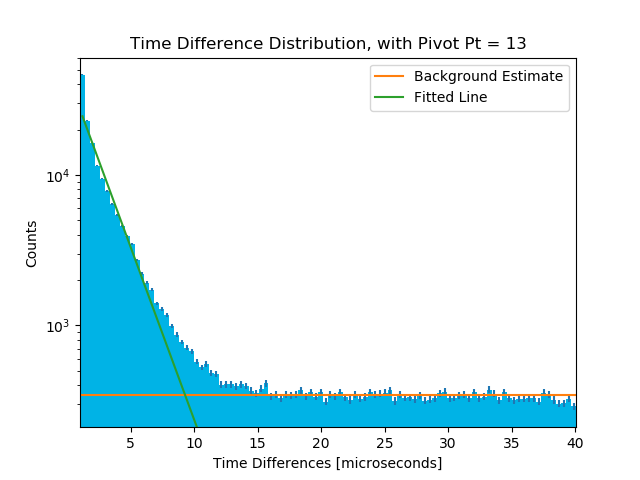

Background average (integer):  342
Slope: -0.527742230785221 +/- 0.010006637816765859
Y-intercept: 10.737183286308198 +/- 0.07879384693089575
Lifetime estimate:  1.8948644653889317
Lifetime estimate range:  [1.9314878358400374, 1.8596040984702602]
Reduced Chi_2:  [0.00066154]


<IPython.core.display.Javascript object>


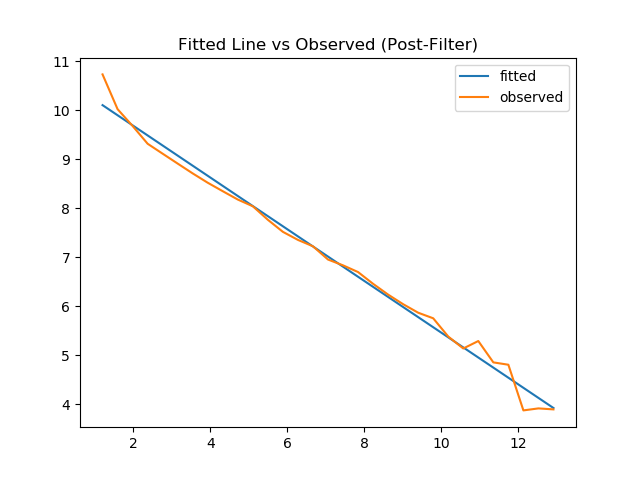

<IPython.core.display.Javascript object>


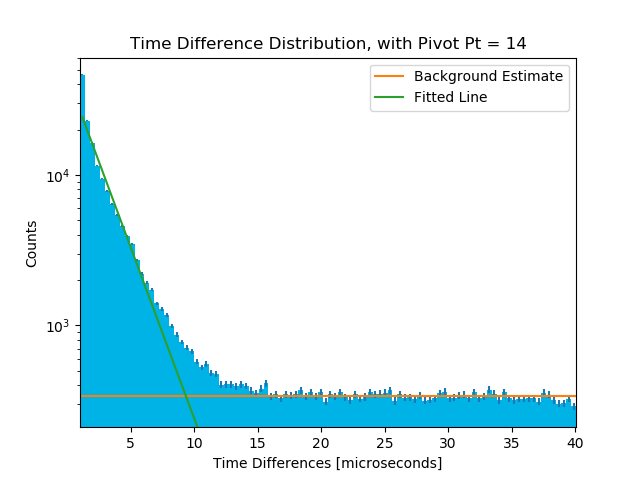

Background average (integer):  340
Slope: -0.5234710206327944 +/- 0.00936337726547441
Y-intercept: 10.714687874370982 +/- 0.0779454832263553
Lifetime estimate:  1.9103254250658552
Lifetime estimate range:  [1.945117939601453, 1.8767557123647347]
Reduced Chi_2:  [0.00049248]


<IPython.core.display.Javascript object>


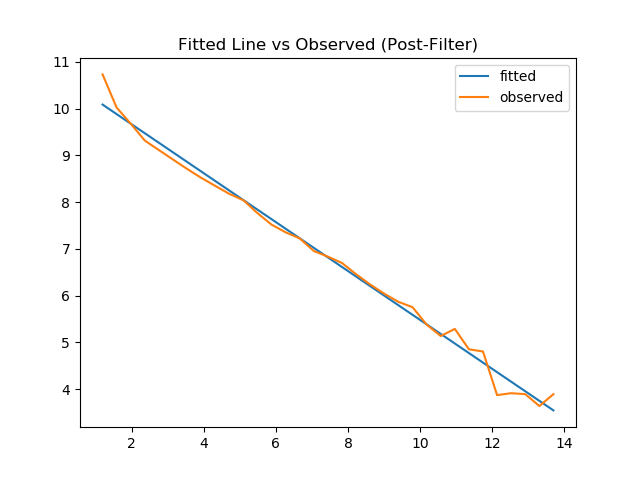

<IPython.core.display.Javascript object>


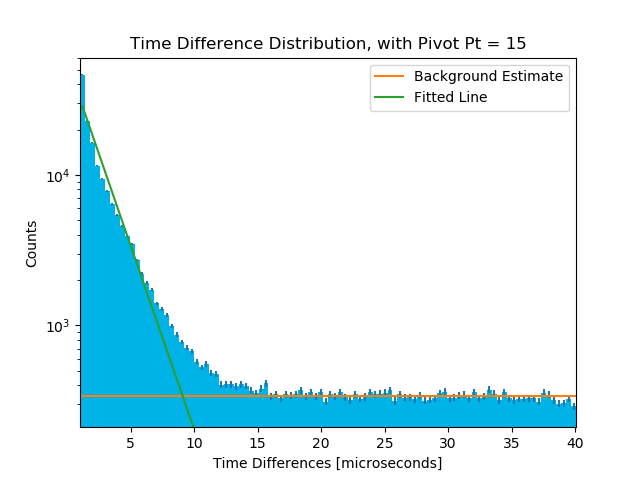

Background average (integer):  338
Slope: -0.5616977385815163 +/- 0.0215000464589923
Y-intercept: 10.929596047223253 +/- 0.19350427934329215
Lifetime estimate:  1.7803169415019378
Lifetime estimate range:  [1.8511741434341167, 1.7146841528736956]
Reduced Chi_2:  [0.00049077]


<IPython.core.display.Javascript object>


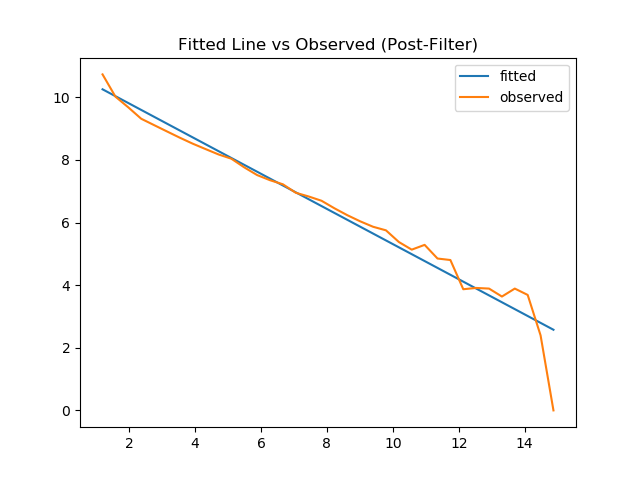

<IPython.core.display.Javascript object>


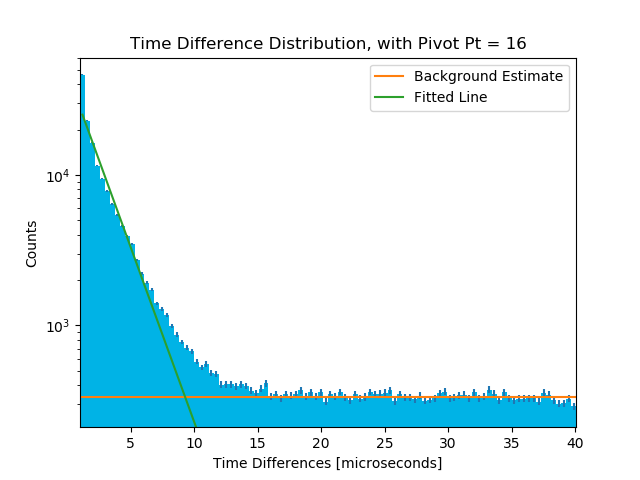

Background average (integer):  336
Slope: -0.5342828355013154 +/- 0.022554236369242007
Y-intercept: 10.769454160759045 +/- 0.21315364818211924
Lifetime estimate:  1.8716678387425718
Lifetime estimate range:  [1.9541608612379067, 1.7958574428975167]
Reduced Chi_2:  [0.00023145]


<IPython.core.display.Javascript object>


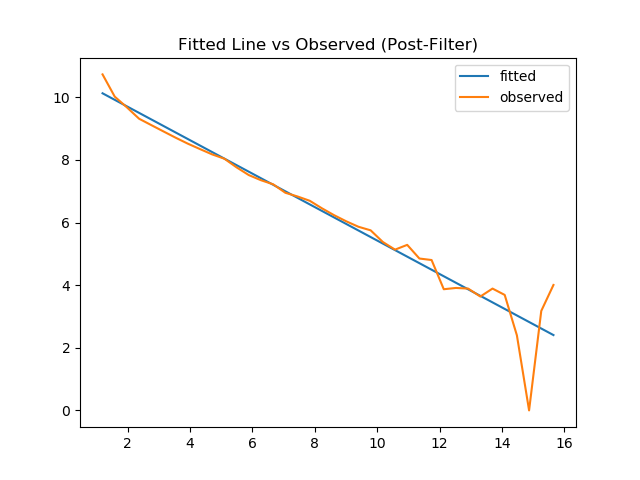

<IPython.core.display.Javascript object>


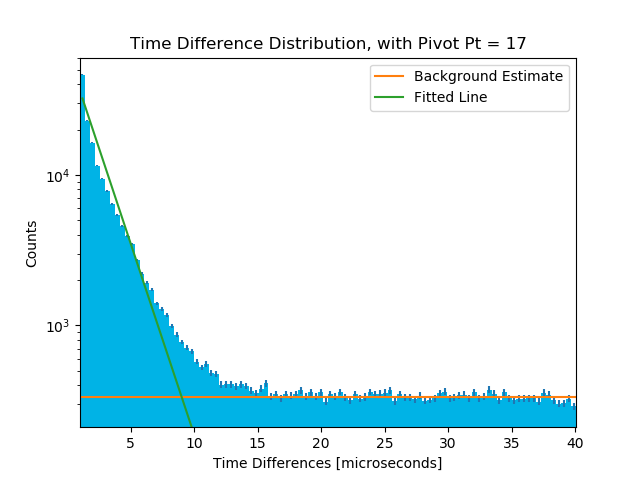

Background average (integer):  336
Slope: -0.5846568223931023 +/- 0.025165054673815173
Y-intercept: 11.077749559137864 +/- 0.2548369918750619
Lifetime estimate:  1.7104050815773013
Lifetime estimate range:  [1.7873363965235824, 1.6398230985246651]
Reduced Chi_2:  [0.00036227]


<IPython.core.display.Javascript object>


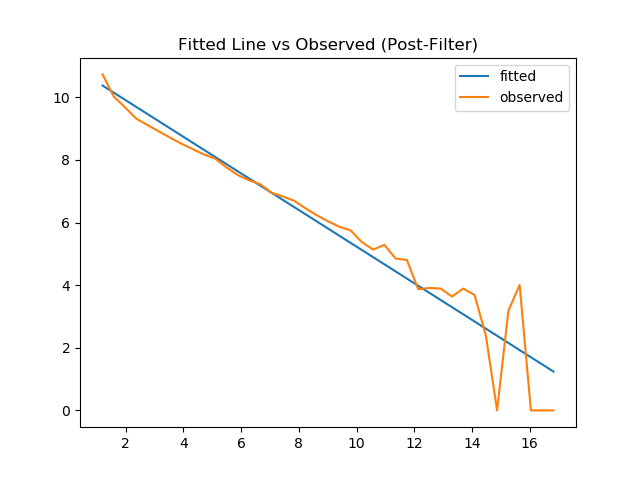

<IPython.core.display.Javascript object>


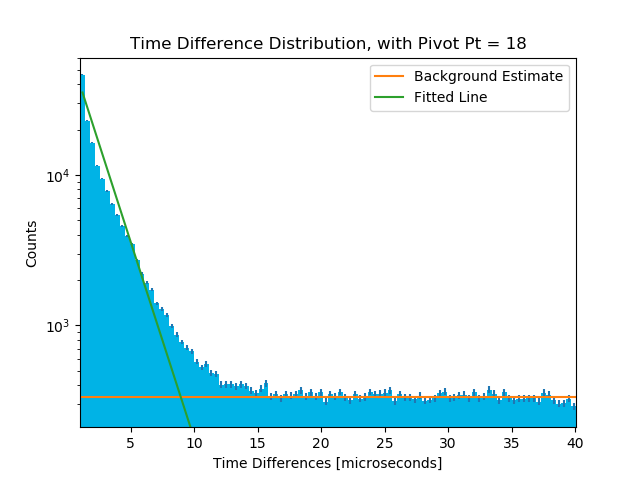

Background average (integer):  336
Slope: -0.601896396022227 +/- 0.022556129927623673
Y-intercept: 11.189688055756998 +/- 0.2436656250766497
Lifetime estimate:  1.6614154971000552
Lifetime estimate range:  [1.7261013233917097, 1.601402762329941]
Reduced Chi_2:  [0.00012858]


<IPython.core.display.Javascript object>


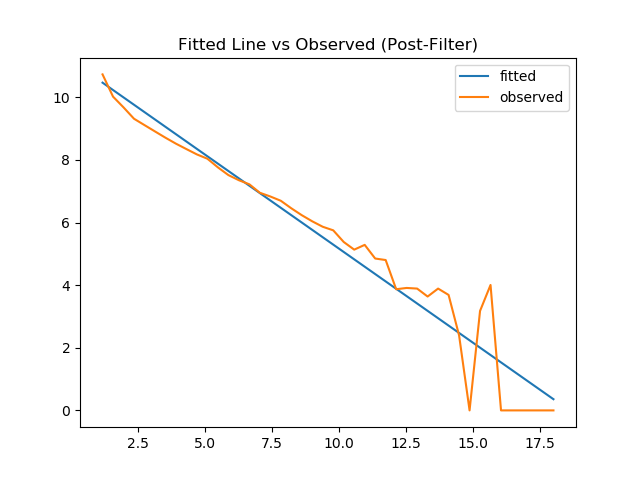

<IPython.core.display.Javascript object>


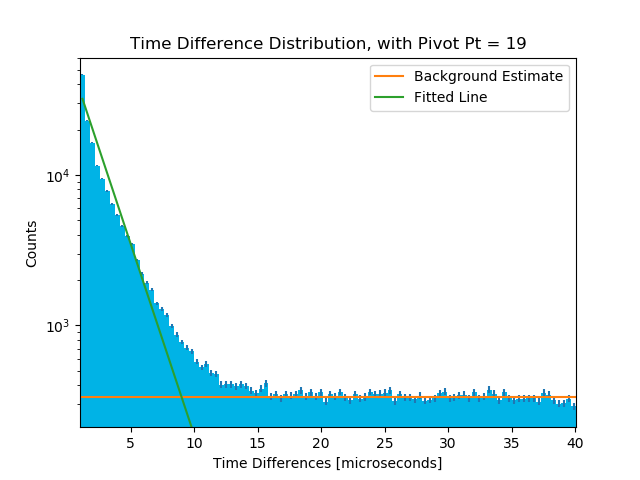

Background average (integer):  335
Slope: -0.5845202093247222 +/- 0.022919435551918263
Y-intercept: 11.07170174202347 +/- 0.25792062419192024
Lifetime estimate:  1.7108048345415954
Lifetime estimate range:  [1.7806243272815554, 1.6462540903188518]
Reduced Chi_2:  [9.96483172e-05]


<IPython.core.display.Javascript object>


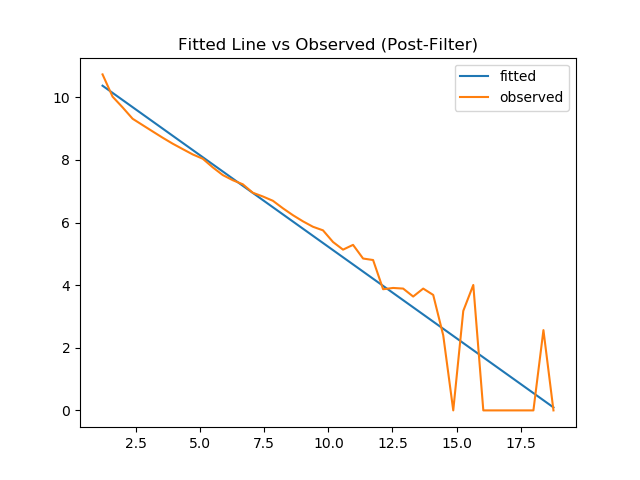

<IPython.core.display.Javascript object>


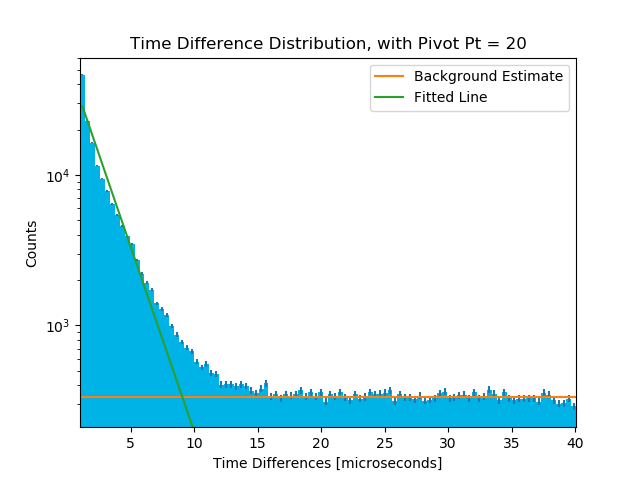

Background average (integer):  334
Slope: -0.5652232244215278 +/- 0.02151928943226629
Y-intercept: 10.93222410020635 +/- 0.2567145152783693
Lifetime estimate:  1.7692125107269614
Lifetime estimate range:  [1.8392362748298863, 1.7043251109108863]
Reduced Chi_2:  [0.00011599]


<IPython.core.display.Javascript object>


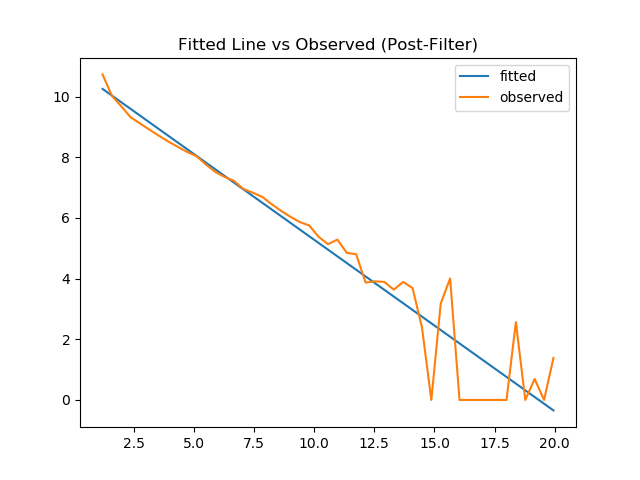

In [349]:
time_diffs = ch0_t2 - ch0_t1
time_diffs_microsec = time_diffs * (10**6)
nbins = 100
lim = [np.min(time_diffs_microsec), np.max(time_diffs_microsec)]
# n, bincenters, patches, errs = plot_histogram(time_diffs_microsec, 'Time Differences [microseconds]', 'Counts', "Time Difference Distribution", nbins, lim, False, True)


# retrieve indices of bins that are 15 us and above

####

pivot_pts = range(10,21)

####
slopes = []
yints = []
total_fitted_vals = []

for pivot_pt in pivot_pts:
    
    pt_str = str(pivot_pt)
    title_str = "Time Difference Distribution, with Pivot Pt = " + pt_str
    
    n, bincenters, patches, errs = plot_histogram(time_diffs_microsec, 
                                                  'Time Differences [microseconds]', 
                                                  'Counts', 
                                                  title_str, 
                                                  nbins, 
                                                  lim, 
                                                  False, 
                                                  True)

    
    ind_15_and_above = np.argwhere(bincenters > pivot_pt)
    background_counts = n[ind_15_and_above]
    background_avg = int(np.average(background_counts))
    print('Background average (integer): ', background_avg)

    x = np.linspace(0,40,1000)
    background_line = np.ones(len(x))*background_avg
    plt.plot(x,background_line, label = "Background Estimate")

    filtered_counts = n - background_avg
    # negative counts dont really make sense, so I set negative values to zero.
    filtered_counts[np.argwhere(filtered_counts <= 0)] = 1
    
    ind_LT_10 = np.argwhere(bincenters <= pivot_pt)
    bins_LT10 = bincenters[ind_LT_10]
    ln_counts_LT10 = ln_counts[ind_LT_10]
    ln_errs_LT10 = ln_errs[ind_LT_10]
    
    # need to convert to list, because curve_fit didnt like my formatting
    bins_list = []
    ln_counts_list = []

    for i in range(len(bins_LT10)):
        bins_list.append(bins_LT10[i][0])
        ln_counts_list.append(ln_counts_LT10[i][0])

    popt, pcov = curve_fit(line_func, bins_list, ln_counts_list)
    paramerr = np.sqrt(np.diag(pcov))

    slope = popt[0]
    yint = popt[1]
    slope_err = paramerr[0]
    yint_err = paramerr[1]
    
    slopes.append(slope)
    yints.append(yint)
    
    lifetime_est = (-1)/slope
    lifetime_est_range = [(-1)/(slope + slope_err), (-1)/(slope - slope_err)]

    print("Slope:", slope, "+/-", slope_err)
    print("Y-intercept:", yint, "+/-", yint_err)
    print("Lifetime estimate: ", lifetime_est)
    # print("N0 estimate: ", N0_est)
    print("Lifetime estimate range: ", lifetime_est_range)

    chi2 = 0
    for i in range(len(popt)):
        chi2 += ((ln_counts_LT10[i] - fittedvals[i])**2)/(ln_errs_LT10[i]**2)

    df = len(fittedvals) - len(popt)
    reduced_chi2 = chi2/df
    print('Reduced Chi_2: ', reduced_chi2)

    fittedvals = line_func(bins_LT10, slope, yint)
    total_fitted_vals.append(fittedvals)
    plt.plot(bins_LT10, np.exp(fittedvals), label = 'Fitted Line')
    plt.legend()
    
    ###
    
    
    plt.figure()
    plt.title("Fitted Line vs Observed (Post-Filter)")
    plt.plot(bins_LT10, fittedvals, label = 'fitted')
    plt.plot(bins_LT10, ln_counts_LT10, label = 'observed')
    plt.legend()


slopes = np.array(slopes)
avg_slope = np.average(slopes)
yints = np.array(yints)
avg_yint = np.average(yints)

plt.show()

In [315]:
avg_slope

-0.5488353315835844

In [374]:
### Curve fitting to the decay
def decay_func(times, tau_eff, Norm, B):
    return (Norm * np.exp(-1 * times/tau_eff)) + B

In [375]:
fparams, pcov = curve_fit(decay_func, bincenters, n)

In [376]:
print(fparams)

tau_eff = fparams[0]
fitted_norm = fparams[1]
fitted_background = fparams[2]

paramerrs = np.sqrt(np.diag(pcov))
tau_eff_err = paramerrs[0]
norm_err = paramerrs[1]
background_err = paramerrs[2]

print(paramerrs)


[2.00516689e+00 1.14136804e+04 1.77074686e+02]
[1.28739629e-02 7.83177416e+01 3.72954004e+00]


In [377]:
# definition for tau_decay from tau_eff, given in Sutton

tau_cap = 26 #microseconds, given in lab manual

tau_decay = tau_eff/(1 - (tau_eff/tau_cap))

#error propagation
tau_decay_err = tau_eff * np.sqrt(2* (tau_eff_err/tau_eff)**2 )

print('Tau_decay with error = ', tau_decay, "+/-", tau_decay_err, 'us')

print("Ratio err/value = ", tau_decay_err/tau_decay)

print('Expected Tau decay = 2.2 us')

### propagated error at each point
errs = np.sqrt(n)

exp_for_error_prop = np.exp(- bincenters / tau_decay)

# total error per point
total_err = np.sqrt( (norm_err/fitted_norm)**2 + (-1 * tau_eff_err * exp_for_error_prop/tau_eff)**2 + background_err**2)


Tau_decay with error =  2.1727318867533825 +/- 0.018206532991990685 us
Ratio err/value =  0.008379558059138122
Expected Tau decay = 2.2 us


<IPython.core.display.Javascript object>


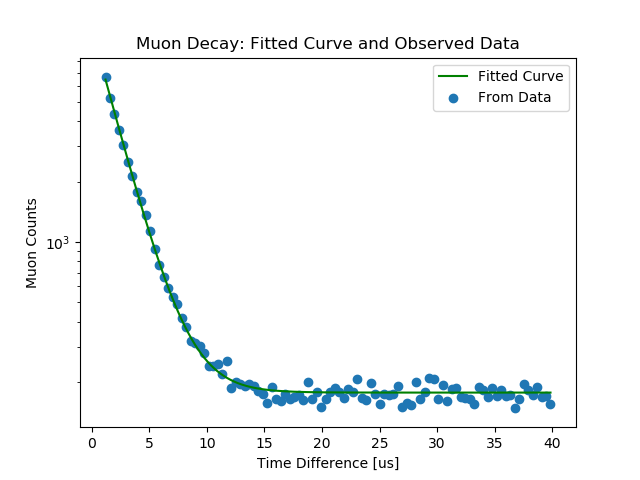

In [378]:
x = np.linspace(np.min(bincenters), np.max(bincenters), 1000)

plt.figure()
plt.title("Muon Decay: Fitted Curve and Observed Data")
plt.xlabel("Time Difference [us]")
plt.ylabel("Muon Counts")
plt.plot(x, decay_func(x, fitted_eff_lambda, fitted_norm, fitted_background),'g', label = 'Fitted Curve')

plt.yscale('log')

plt.scatter(bincenters, n, label = 'From Data')
#plt.errorbar(bincenters, n, yerr = total_err, ecolor = 'r', label = 'error')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


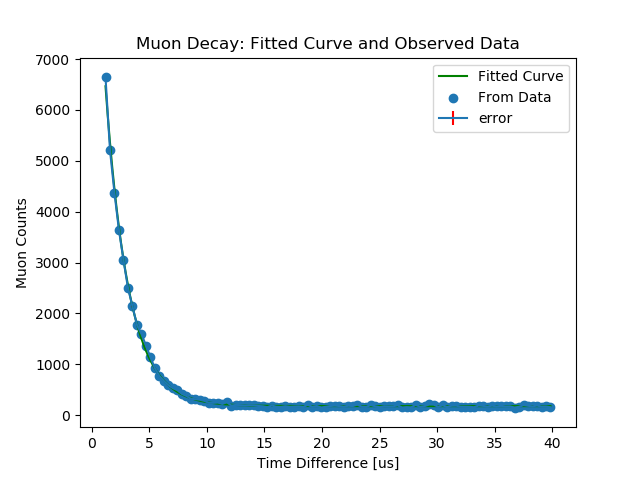

In [379]:
plt.figure()
plt.title("Muon Decay: Fitted Curve and Observed Data")
plt.xlabel("Time Difference [us]")
plt.ylabel("Muon Counts")
plt.plot(x, decay_func(x, fitted_eff_lambda, fitted_norm, fitted_background),'g', label = 'Fitted Curve')

#plt.yscale('log')

plt.scatter(bincenters, n, label = 'From Data')
plt.errorbar(bincenters, n, yerr = total_err, ecolor = 'r', label = 'error')
plt.legend()
plt.show()